# Figs of WMT tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Annual-mean global fig of each term](#first-bullet)
* [Monthly Climatology](#third-bullet)

> Note: the time dimension is for entire 40-yr run of CESM data

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
#options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster()
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.670754b04b3a4bdabbb6cc6390b5b35c/status,


In [16]:
cluster.close()
client.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [ ]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(path):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/'+
                                              path +'_histograms.zarr'))
    return ds
    
natl = xr.merge([open_ds('natl'), open_ds('surf_natl')])
satl = xr.merge([open_ds('satl'), open_ds('surf_satl')])
npac = xr.merge([open_ds('npac'), open_ds('surf_npac')])
spac = xr.merge([open_ds('spac'), open_ds('surf_spac')])
ind = xr.merge([open_ds('ind'), open_ds('surf_ind')])
arc = xr.merge([open_ds('arc'), open_ds('surf_arc')])
south = xr.merge([open_ds('south'), open_ds('surf_south')])

global_hist = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr'))

# Plot NATL ann mean

In [5]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [6]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(path):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/'+
                                              path +'_histograms.zarr'))
    return ds
    
natl = xr.merge([open_ds('natl'), open_ds('surf_natl')])

In [9]:
natl['OMEGA_NATL_surf_salt'] = -natl.OMEGA_NATL_surf_salt

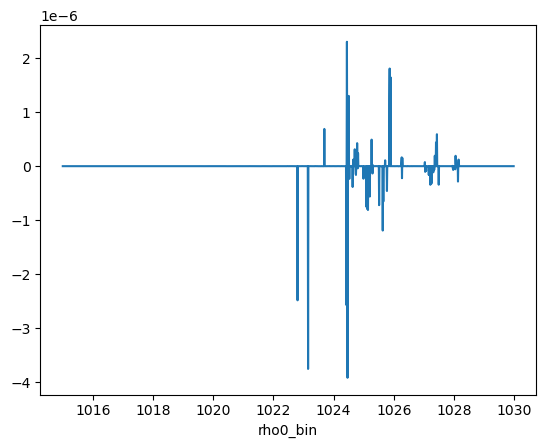

In [10]:
((natl.OMEGA_NATL_rho + natl.OMEGA_NATL_cabbeling - natl.OMEGA_NATL_sss - natl.OMEGA_NATL_sst).mean('time')/1e6).plot()

In [12]:
def ann_mean(ds, basin_title):
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_mix=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    labels_mix = ['cabbeling', r'$\rho$', 'S', r'$\theta$']
    labels_surf = [r'$\theta_{S}$', r'S$_S$']
    
    for (i,j,k) in zip(list(ds.data_vars)[:-2], line_mix, labels_mix): #slicing to mixing terms only
        (ds[i].mean('time')/1e6).plot(label=k, color=j, ax=ax0)
    for (i,j,k) in zip(list(ds.data_vars)[-2:], line_surf, labels_surf): #slicing to surf terms only
        (ds[i].mean('time')/1e6).plot(label=k, color=j, ax=ax1)
        
    #plotting mixing residual
    #((ds[f'OMEGA_{basin_title}_rho'] + ds[f'OMEGA_{basin_title}_cabbeling'] -
      #ds[f'OMEGA_{basin_title}_sss'] - ds[f'OMEGA_{basin_title}_sst']).mean('time')/1e6).plot(label='residual', 
                                                                                                #color='grey', 
                                                                                                #linestyle='dashed', ax=ax0)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylim(-2.5, 1.5)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16, labelpad=5)
    ax0.axvline(x=1026.3, ymin=-2.5, ymax=1.5, color='r', linestyle='--')
    ax0.grid()
    ax0.set_title('Mixing', fontsize=16)
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylim(-15, 30)
    ax1.set_ylabel('')
    ax1.axvline(x=1026.3, ymin=-2.5, ymax=1.5, color='r', linestyle='--')
    ax1.grid()
    ax1.set_title('Air-Sea', fontsize=16)
    ax1.set_xlabel('')
    
    fig.supxlabel('Density', fontsize=16)#, y=-0.02)
    plt.suptitle('CESM', fontsize=20)
    plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

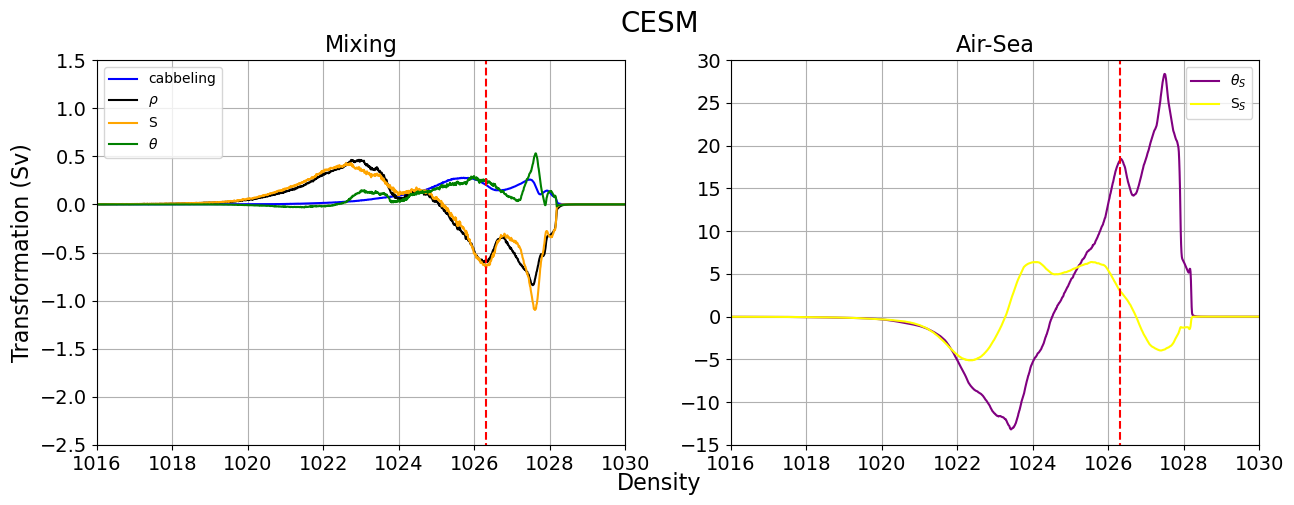

In [13]:
ann_mean(natl, 'NATL')

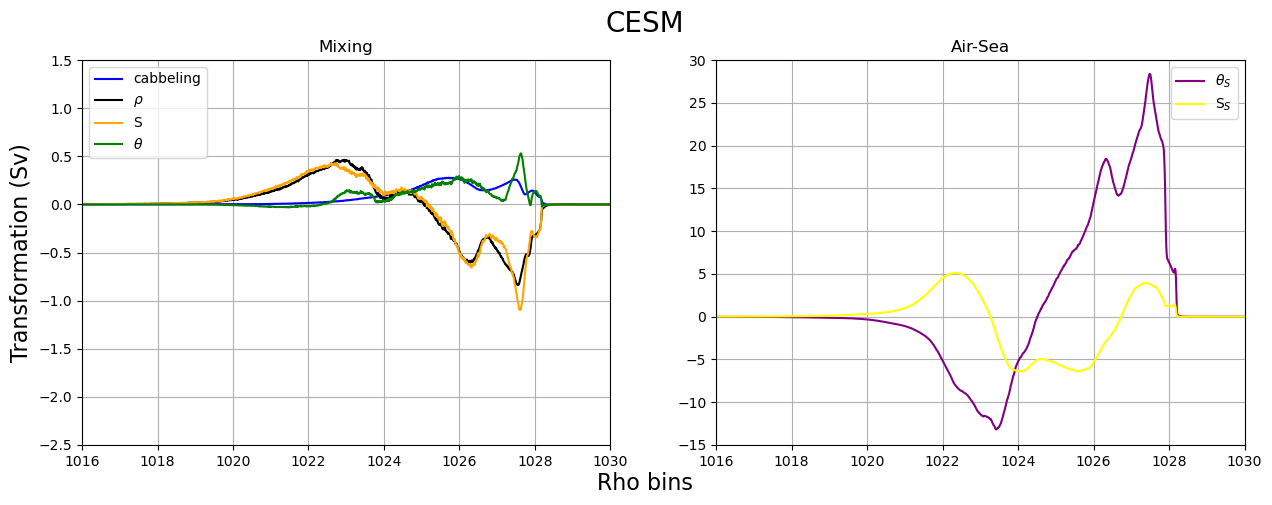

In [9]:
ann_mean(natl, 'NATL')

# 1) Annual-mean global fig <a class='anchor' id='first-bullet'> </a>
(use logarithmic scale on y-axis)

In [6]:
natl

<xarray.Dataset>
Dimensions:               (time: 14965, rho0_bin: 1499)
Coordinates:
  * rho0_bin              (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
  * time                  (time) object 0046-01-02 00:00:00 ... 0087-01-01 00...
Data variables:
    OMEGA_NATL_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

In [7]:
list(natl.data_vars)[-2:]

['OMEGA_NATL_surf_heat', 'OMEGA_NATL_surf_salt']

In [12]:
def ann_mean(ds, basin_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_mix=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    labels_mix = ['cabbeling', r'$\rho$', 'S', r'$\theta$']
    labels_surf = [r'$\theta_{S}$', r'S$_S$']
    
    for (i,j,k) in zip(list(ds.data_vars)[:-2], line_mix, labels_mix): #slicing to mixing terms only
        (ds[i].mean('time')/1e6).plot(label=k, color=j, ax=ax0)
    for (i,j,k) in zip(list(ds.data_vars)[-2:], line_surf, labels_surf): #slicing to surf terms only
        (ds[i].mean('time')/1e6).plot(label=k, color=j, ax=ax1)
        
    #plotting mixing residual
    #((ds[f'OMEGA_{basin_title}_rho'] + ds[f'OMEGA_{basin_title}_cabbeling'] -
      #ds[f'OMEGA_{basin_title}_sss'] - ds[f'OMEGA_{basin_title}_sst']).mean('time')/1e6).plot(label='residual', 
                                                                                                #color='grey', 
                                                                                                #linestyle='dashed', ax=ax0)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.set_ylim(-2.5, 1.5)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing')
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.set_ylim(-15, 30)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Air-Sea')
    ax1.set_xlabel('')
    
    fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('CESM', fontsize=20)
    plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

2023-09-15 21:10:55,360 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


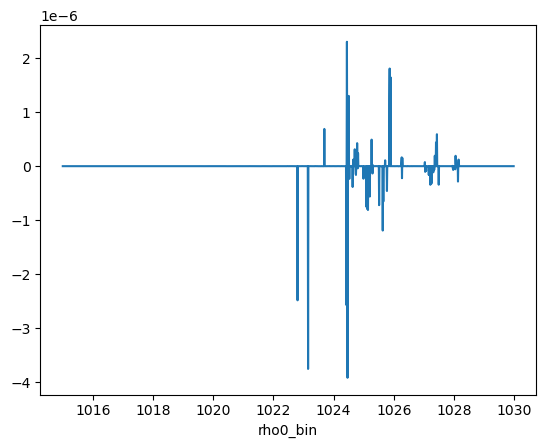

In [8]:
((natl.OMEGA_NATL_rho + natl.OMEGA_NATL_cabbeling - natl.OMEGA_NATL_sss - natl.OMEGA_NATL_sst).mean('time')/1e6).plot()

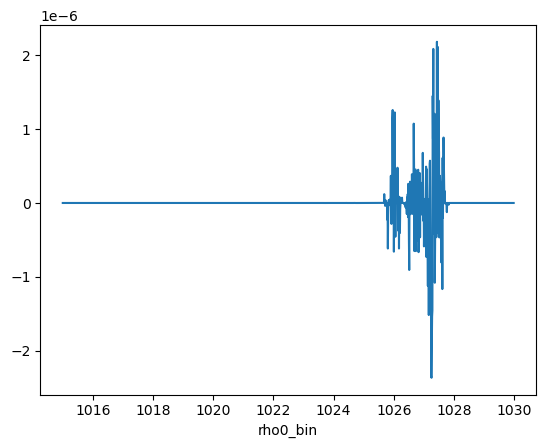

In [16]:
((south.OMEGA_South_rho + south.OMEGA_South_cabbeling - south.OMEGA_South_sss - south.OMEGA_South_sst)/1e6).mean('time').plot()

## 1a) Annual-mean North ATL fig

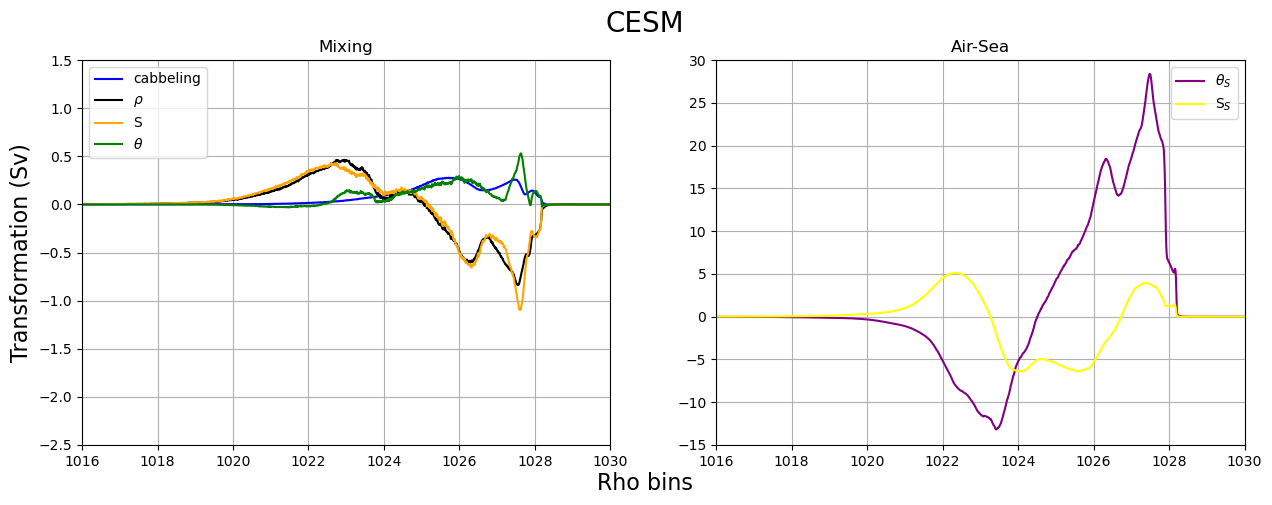

In [9]:
ann_mean(natl, 'NATL')

## 1b) Annual-mean South ATL fig

In [ ]:
ann_mean(satl, 'SATL')

## 1c) Annual-mean North PAC fig

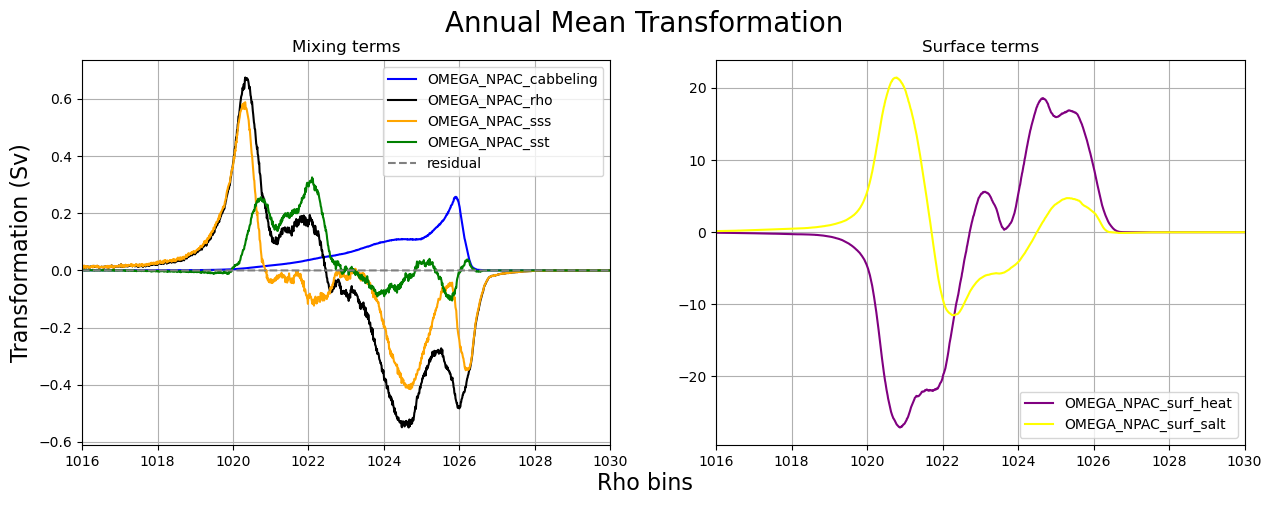

In [11]:
ann_mean(npac, 'NPAC')

## 1d) Annual-mean South PAC fig

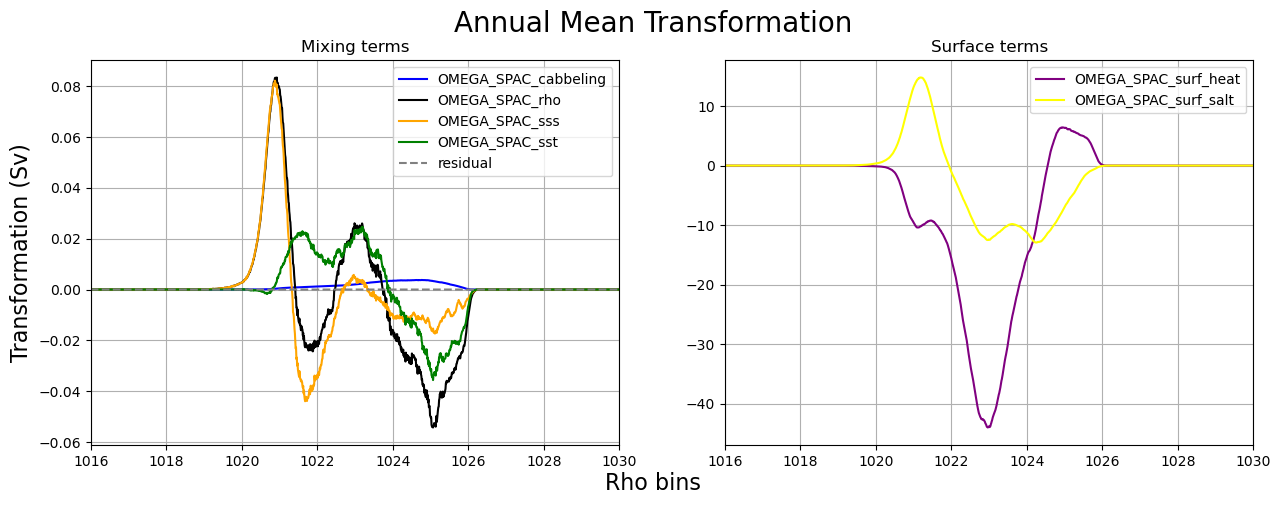

In [12]:
ann_mean(spac, 'SPAC')

## 1e) Annual-mean IND fig

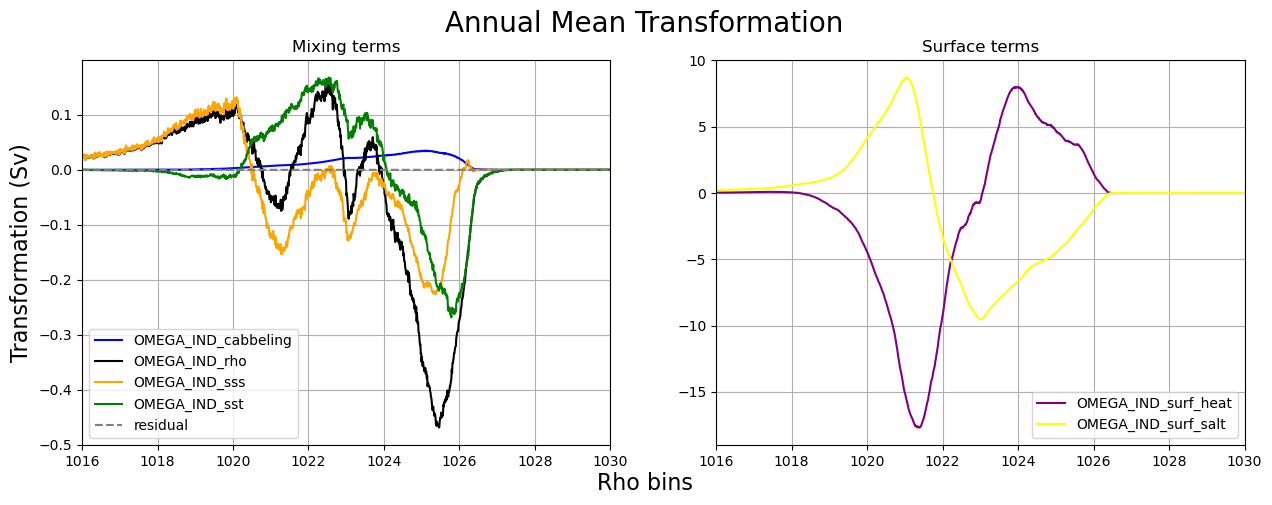

In [13]:
ann_mean(ind, 'IND')

## 1f) Annual-mean ARC fig

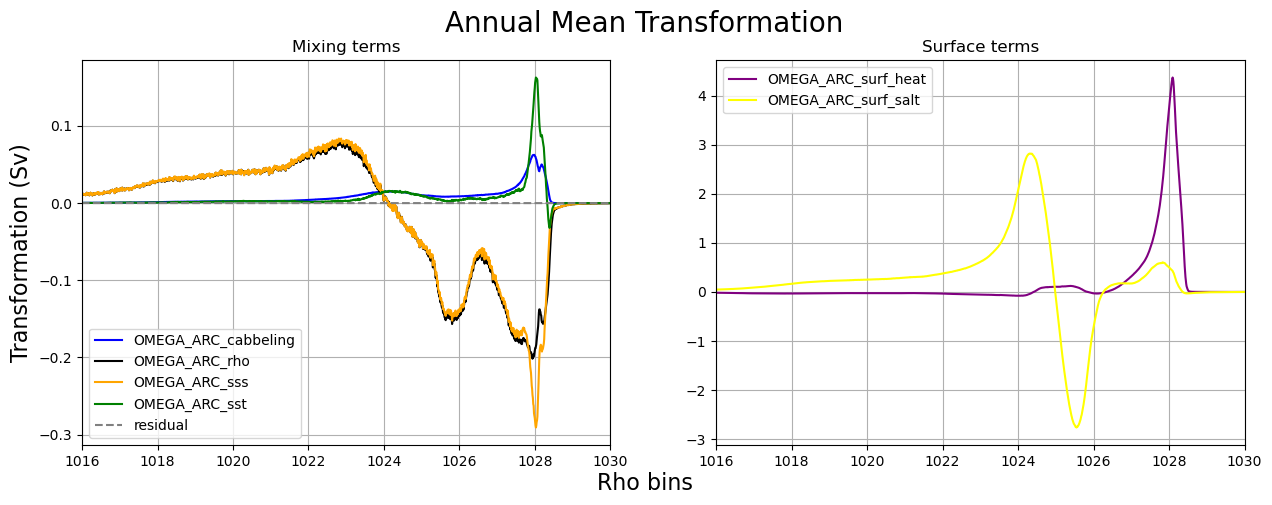

In [14]:
ann_mean(arc, 'ARC')

## 1g) Annual-mean South fig

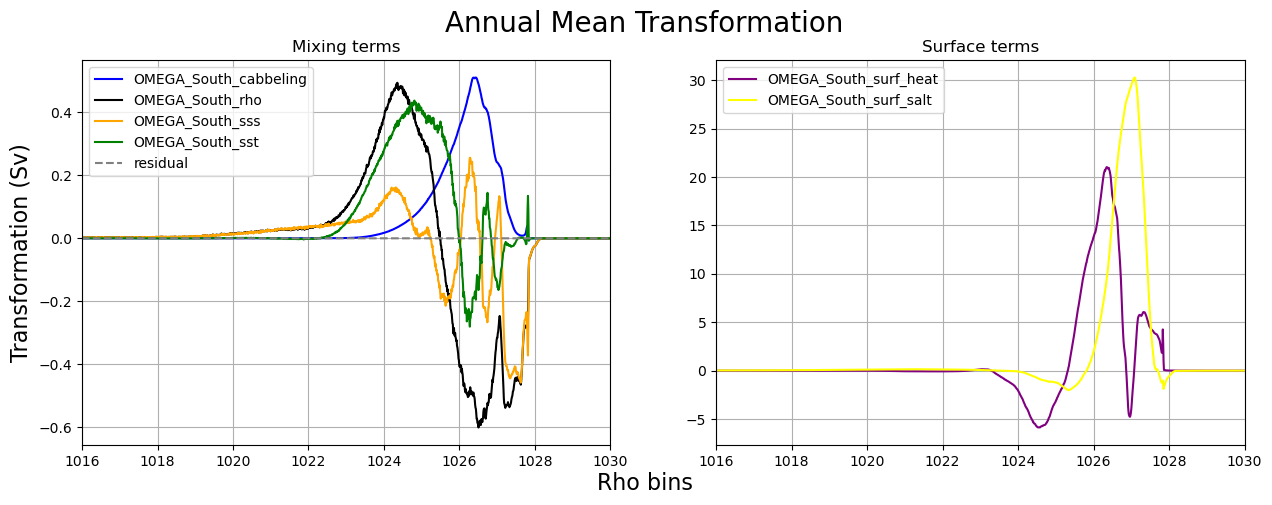

In [15]:
ann_mean(south, 'South')

# 3) Global Monthly Climatology <a class='anchor' id='third-bullet'> </a>

In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
def clim(da):
    clim = (da/1e6).groupby('time.month').mean(dim='time')
    return clim

In [42]:
clim_global = clim(global_hist)
clim_natl = clim(natl)
clim_satl = clim(satl)
clim_npac = clim(npac)
clim_spac = clim(spac)
clim_ind = clim(ind)
clim_arc = clim(arc)
clim_south = clim(south)

In [60]:
def plotting_global(ds, scale):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

    levels = np.arange(-200, 200) + 10

    ds.OMEGA_rho.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
    axes[0,0].set_title(r'Density ($\rho_0$)')
    axes[0,0].set_ylim(1029, 1018)
    axes[0,0].grid()

    ds.OMEGA_cabbeling.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
    axes[0,1].set_title('Cabbeling')
    axes[0,1].set_ylim(1029, 1018)
    axes[0,1].grid()

    ds.OMEGA_sst.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
    axes[1,0].set_title('SST')
    axes[1,0].set_ylim(1029, 1018)
    axes[1,0].grid()

    ds.OMEGA_sss.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
    axes[1,1].set_title('SSS')
    axes[1,1].set_ylim(1029, 1018)
    axes[1,1].grid()

    plt.suptitle(f'{scale} transformation due to ...', fontsize=20, y=1)
    plt.tight_layout();

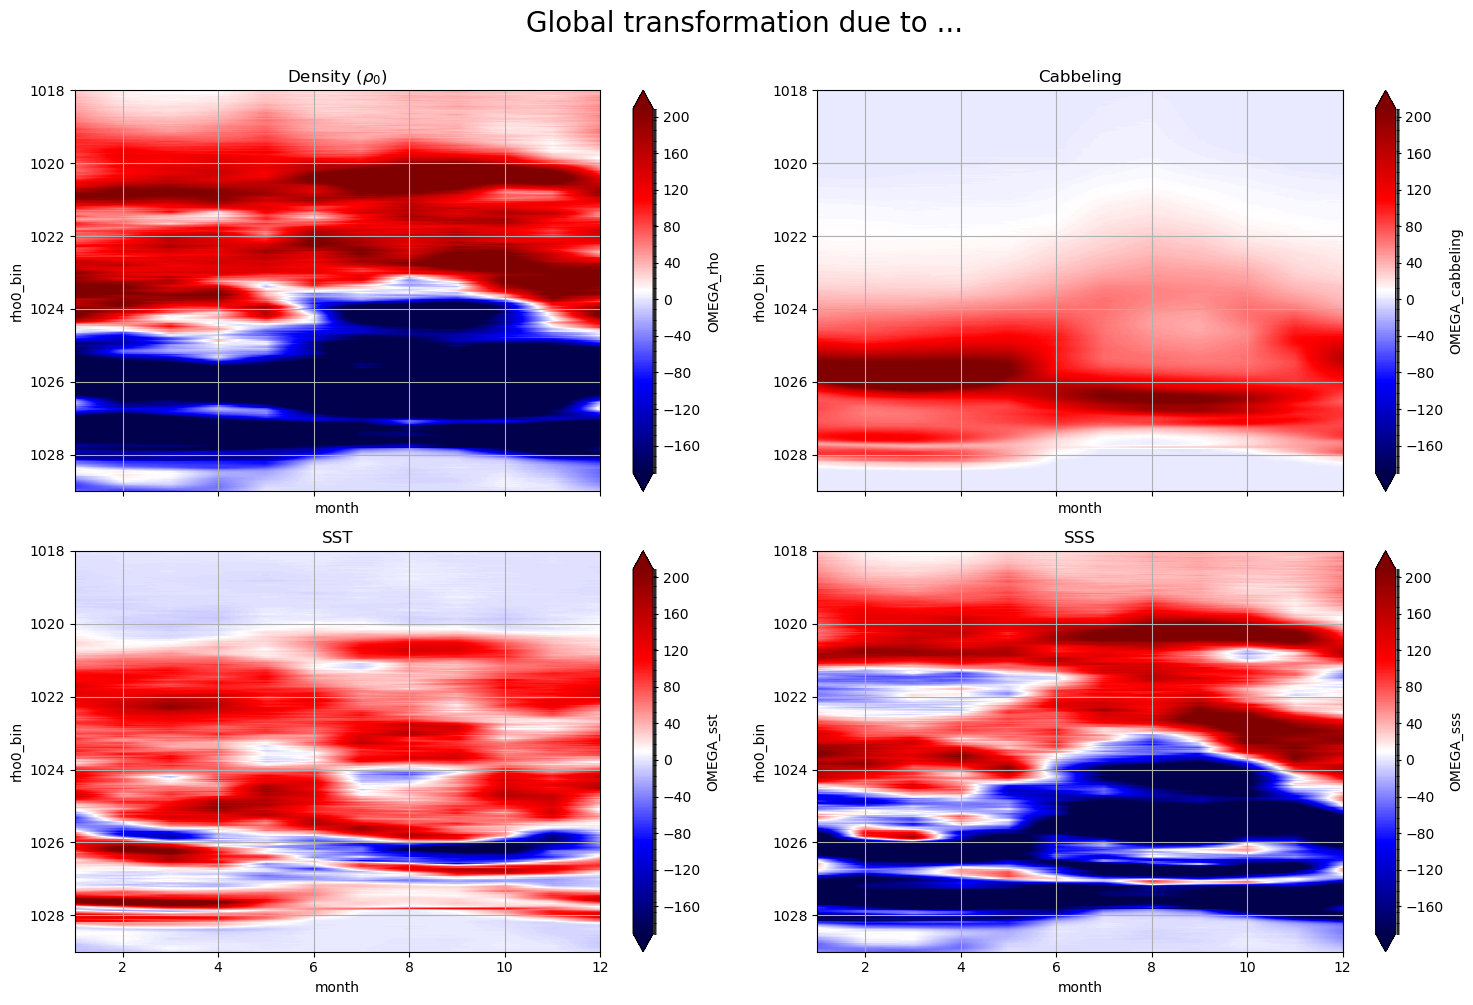

In [61]:
plotting_global(clim_global, 'Global')

## 3a) ATL monthly climatology

In [58]:
def plotting(ds, prefix, scale):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)

    levels = np.arange(-1.5, 1.5, 0.1)
    levels_surf = np.arange(-30, 30, 5)

    ds[f'OMEGA_{prefix}rho'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
    axes[0,0].set_title(r'Density ($\rho_0$)')
    axes[0,0].set_ylim(1029, 1018)
    axes[0,0].grid()

    ds[f'OMEGA_{prefix}cabbeling'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
    axes[0,1].set_title('Cabbeling')
    axes[0,1].set_ylim(1029, 1018)
    axes[0,1].grid()

    ds[f'OMEGA_{prefix}sst'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
    axes[1,0].set_title('SST')
    axes[1,0].set_ylim(1029, 1018)
    axes[1,0].grid()

    ds[f'OMEGA_{prefix}sss'].plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
    axes[1,1].set_title('SSS')
    axes[1,1].set_ylim(1029, 1018)
    axes[1,1].grid()

    ds[f'OMEGA_{prefix}surf_heat'].plot.contourf(x='month', cmap='seismic', levels=levels_surf, 
                                                 extend='both', ax=axes[2,0])
    axes[2,0].set_title('Surf_heat')
    axes[2,0].set_ylim(1029, 1018)
    axes[2,0].grid()

    ds[f'OMEGA_{prefix}surf_salt'].plot.contourf(x='month', cmap='seismic', levels=levels_surf, 
                                                 extend='both', ax=axes[2,1])
    axes[2,1].set_title('Surf_salt')
    axes[2,1].set_ylim(1029, 1018)
    axes[2,1].grid()

    plt.suptitle(f'{scale} transformation due to ...', fontsize=20, y=1)
    plt.tight_layout();

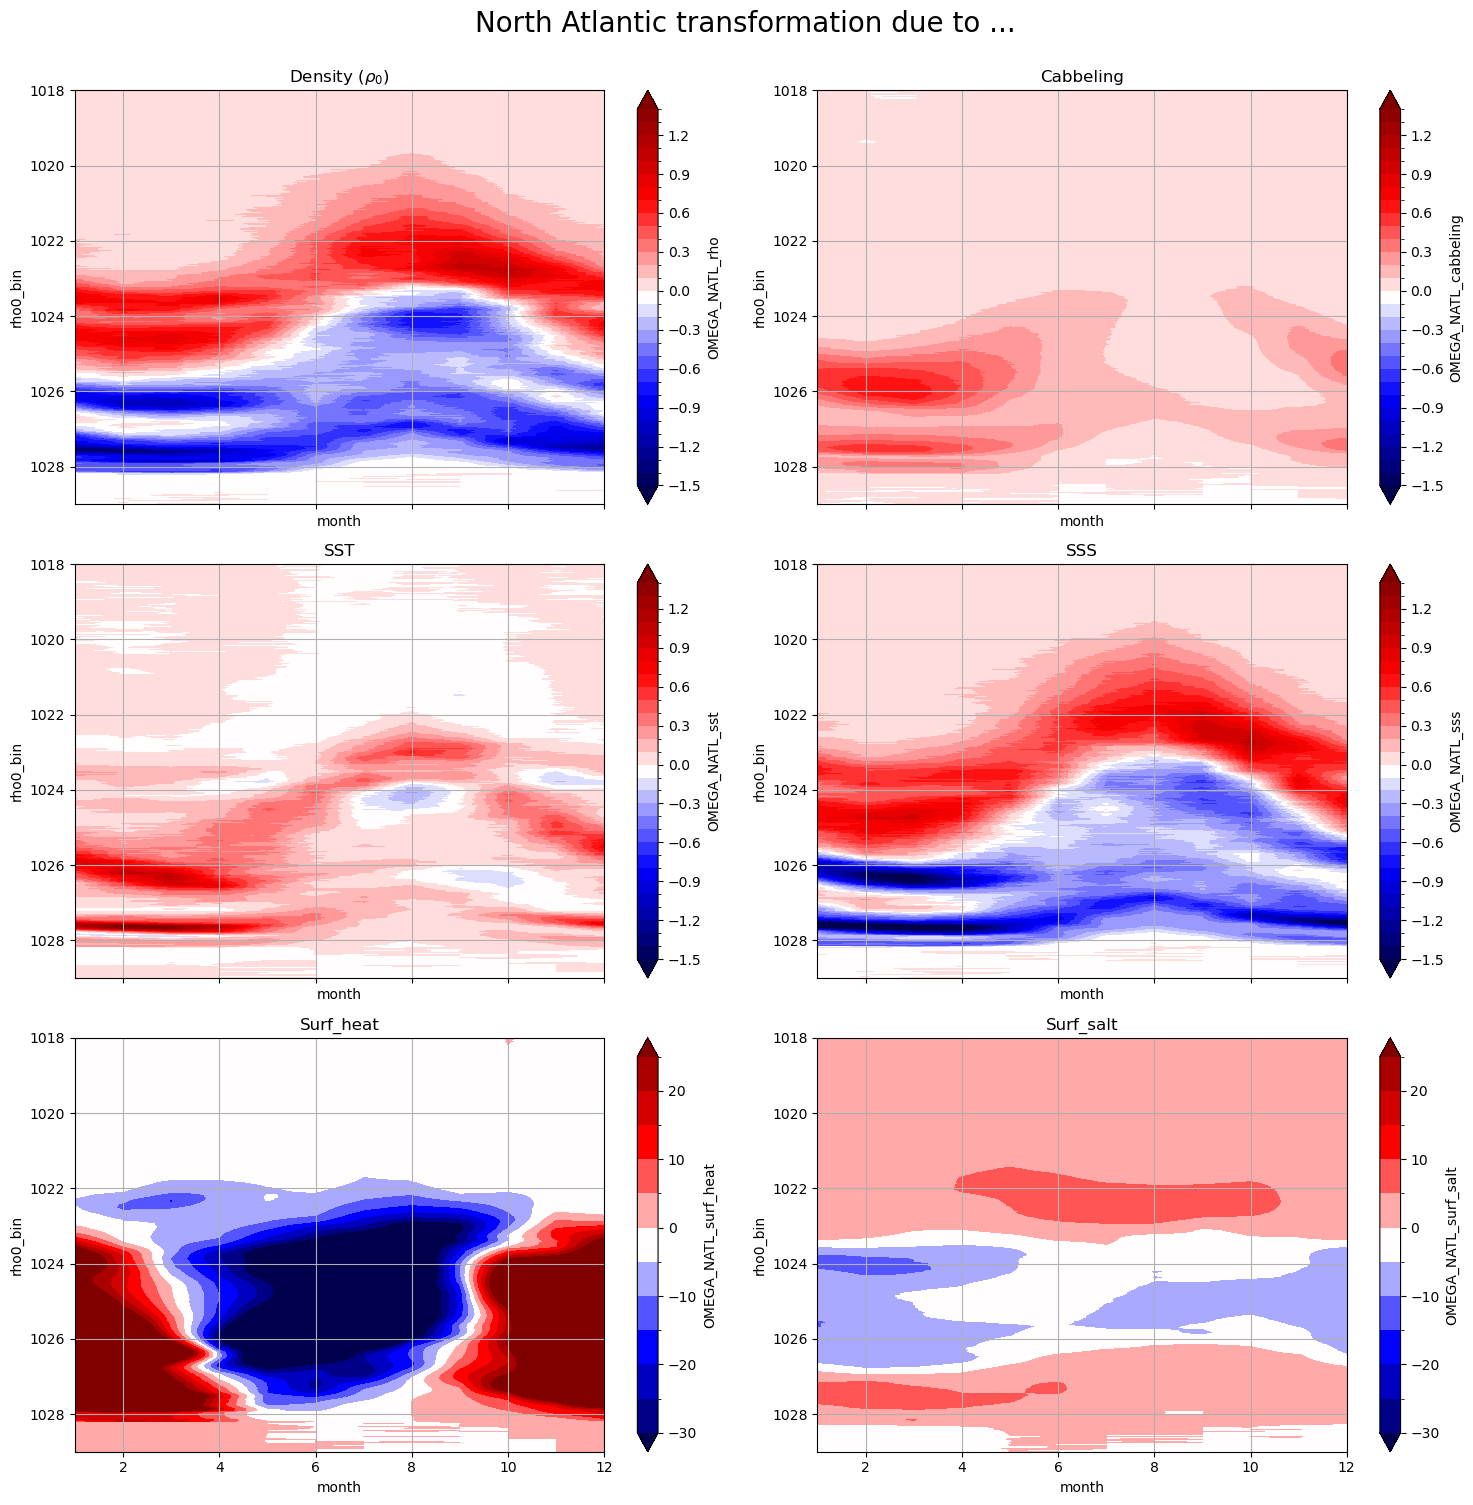

In [66]:
plotting(clim_natl, 'NATL_', 'North Atlantic')

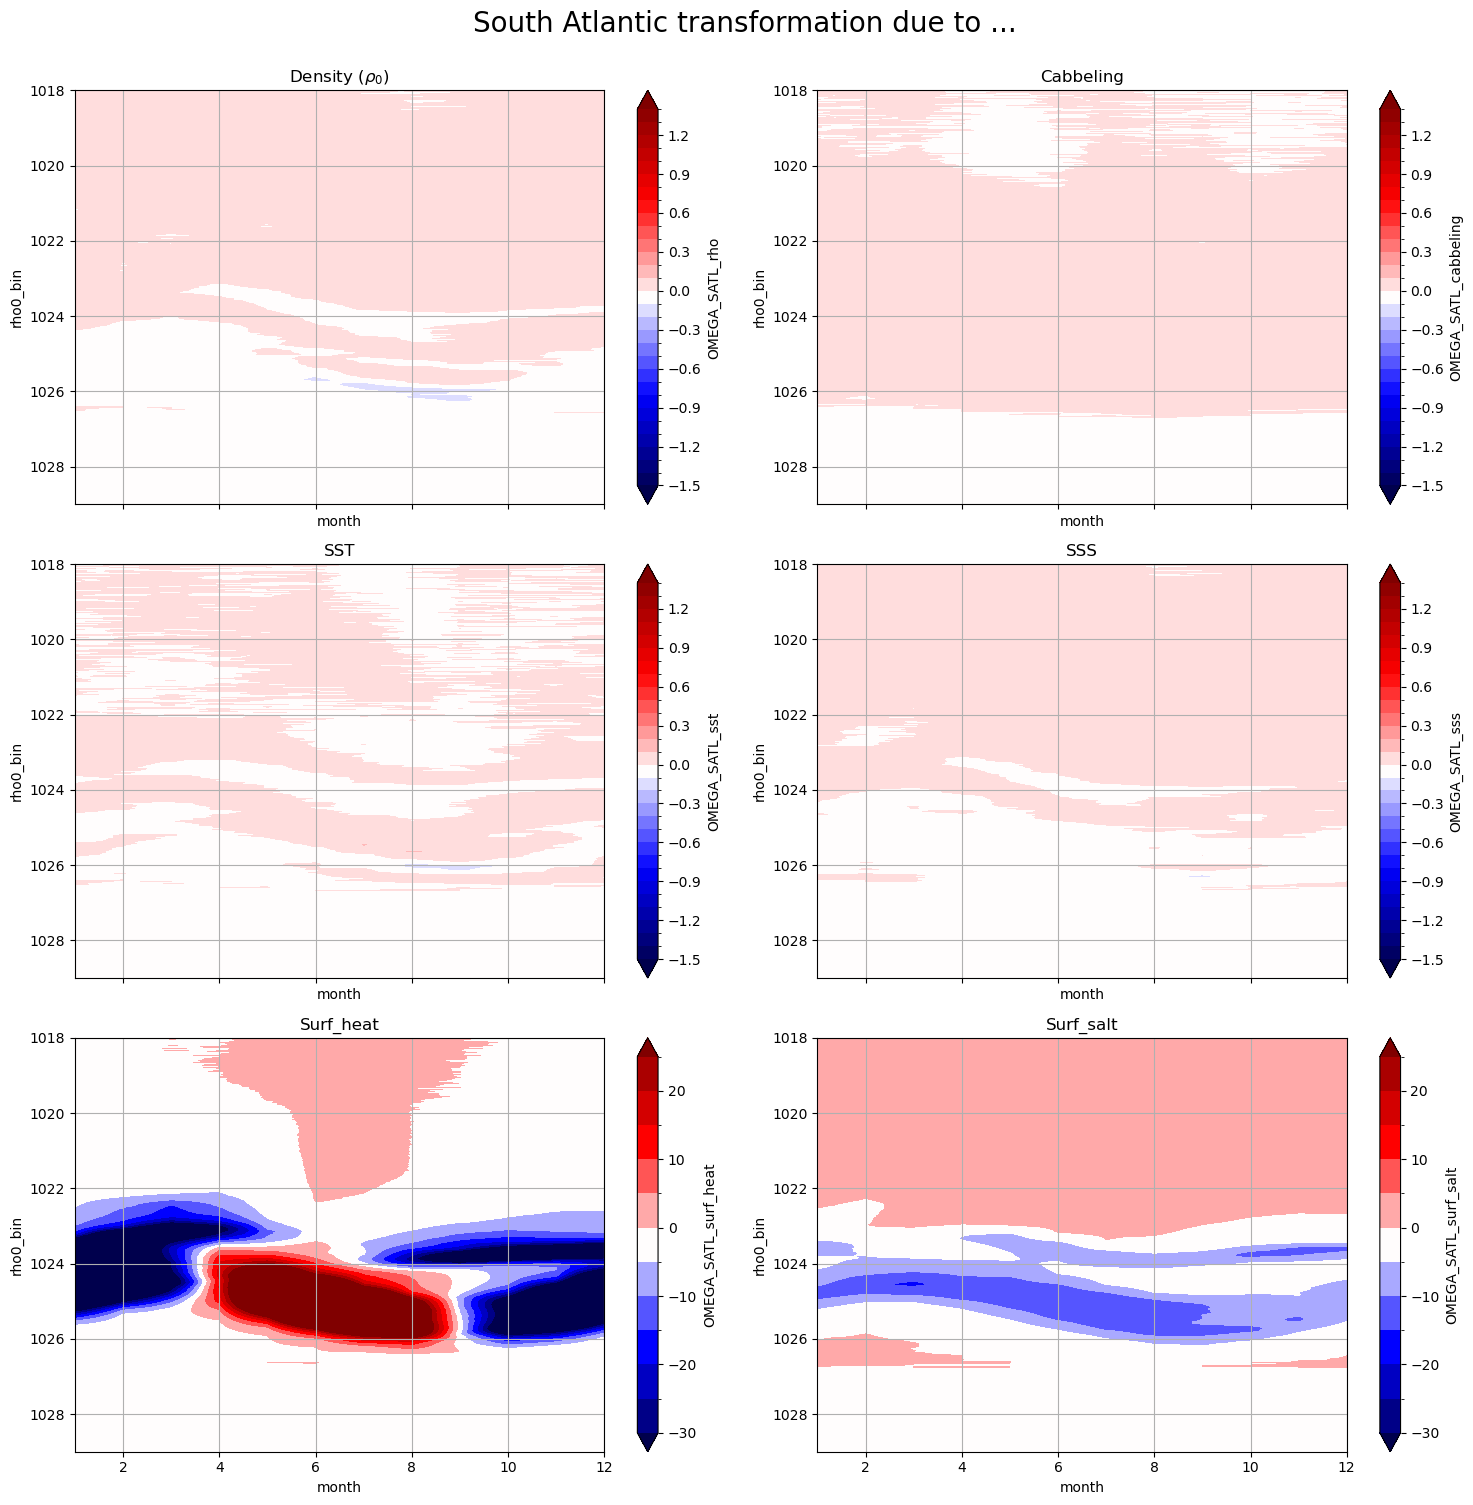

In [67]:
plotting(clim_satl, 'SATL_', 'South Atlantic')

## 3b) PAC monthly climatology

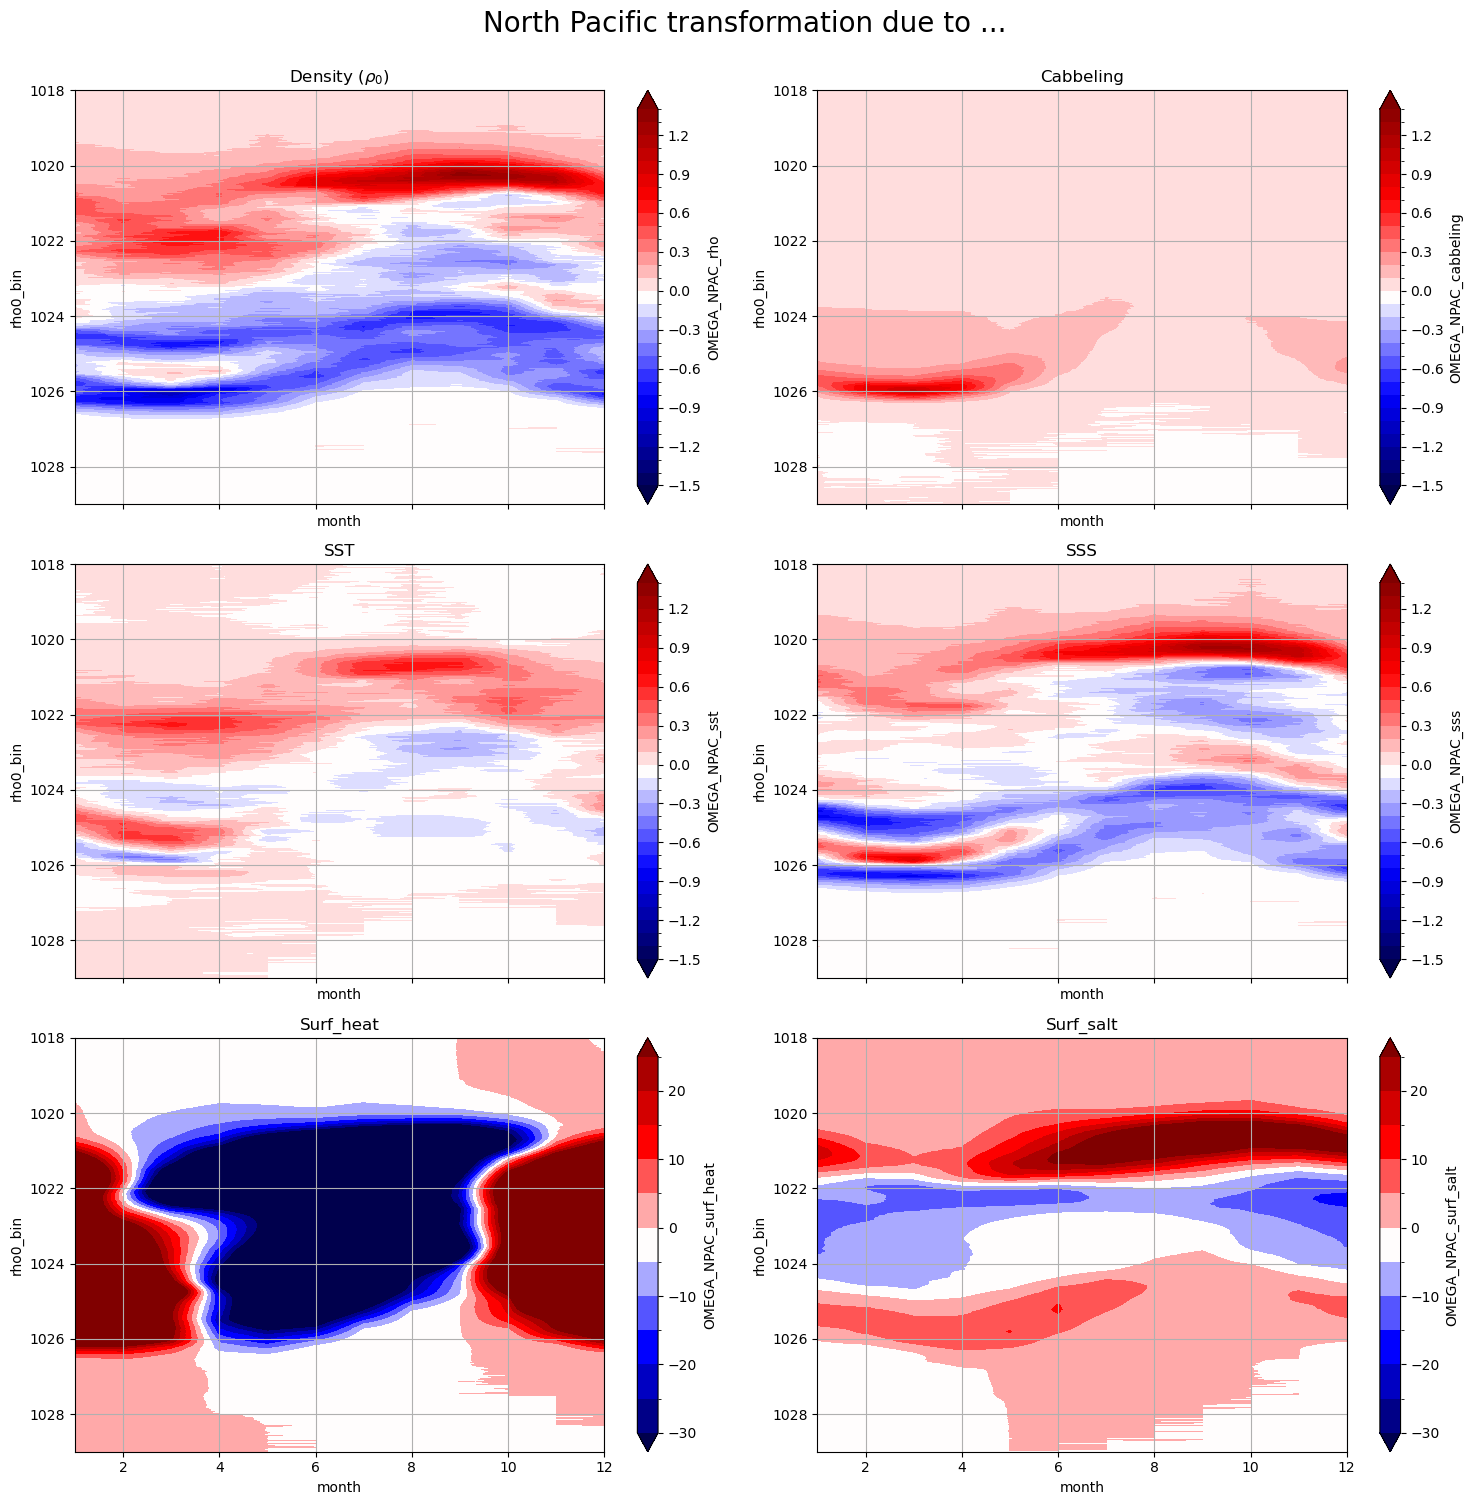

In [68]:
plotting(clim_npac, 'NPAC_', 'North Pacific')

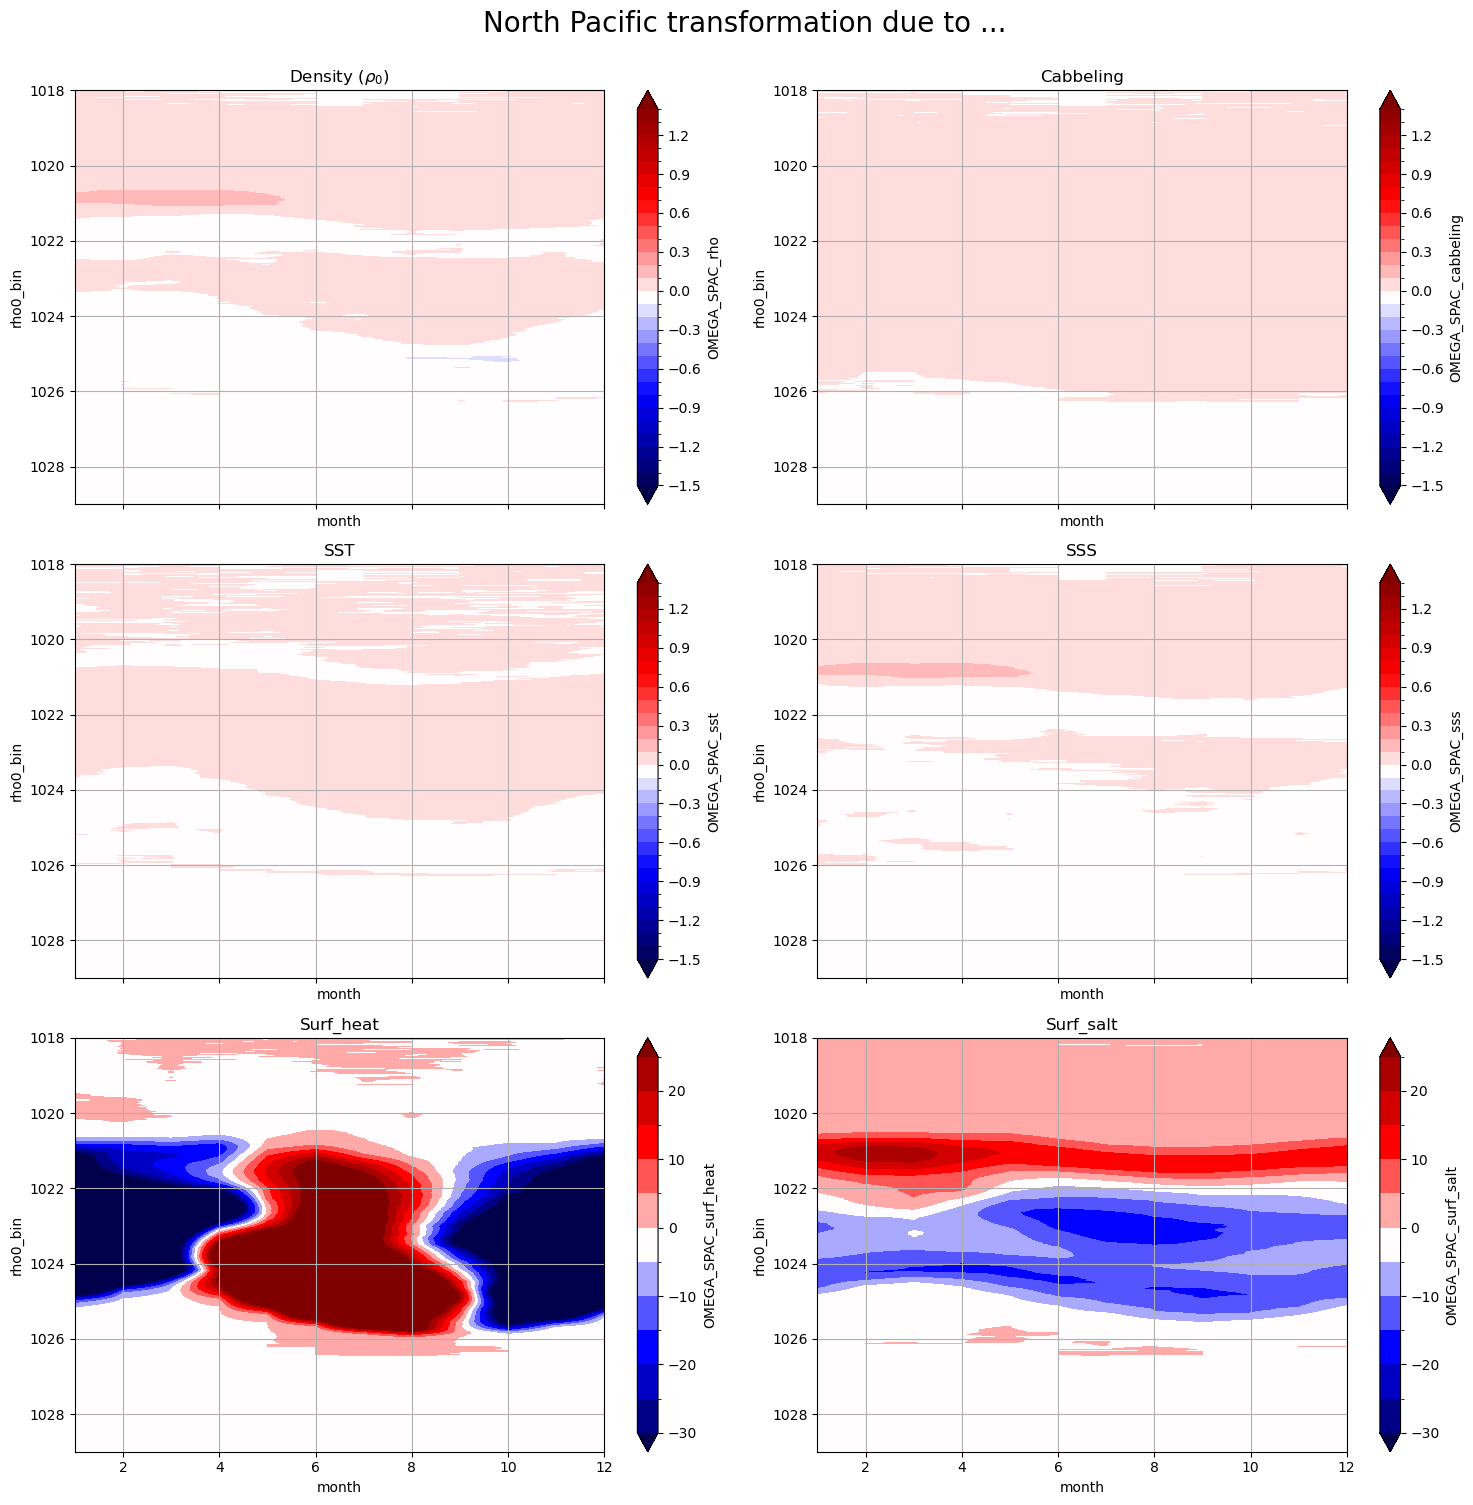

In [69]:
plotting(clim_spac, 'SPAC_', 'North Pacific')

## 3c) IND monthly climatology

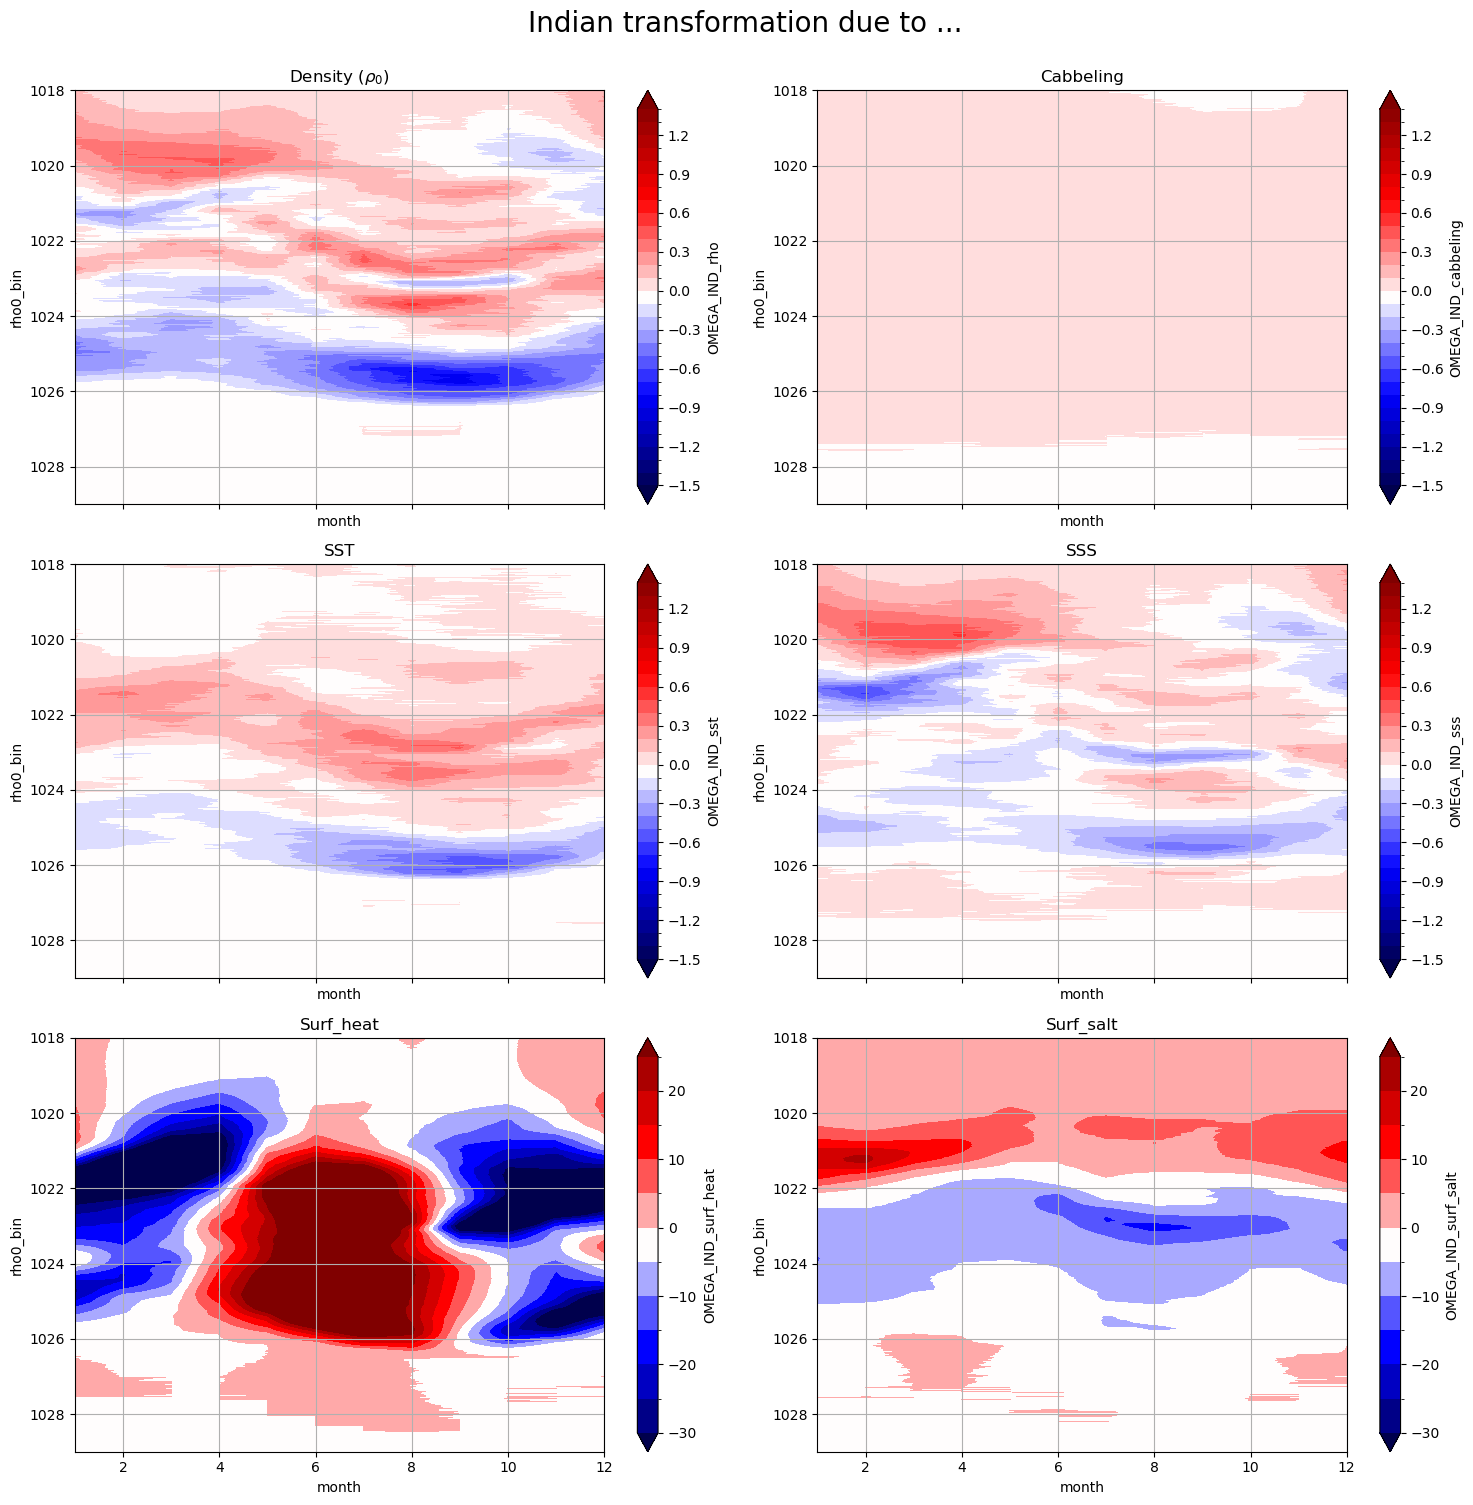

In [70]:
plotting(clim_ind, 'IND_', 'Indian')

## 3d) ARC monthly climatology

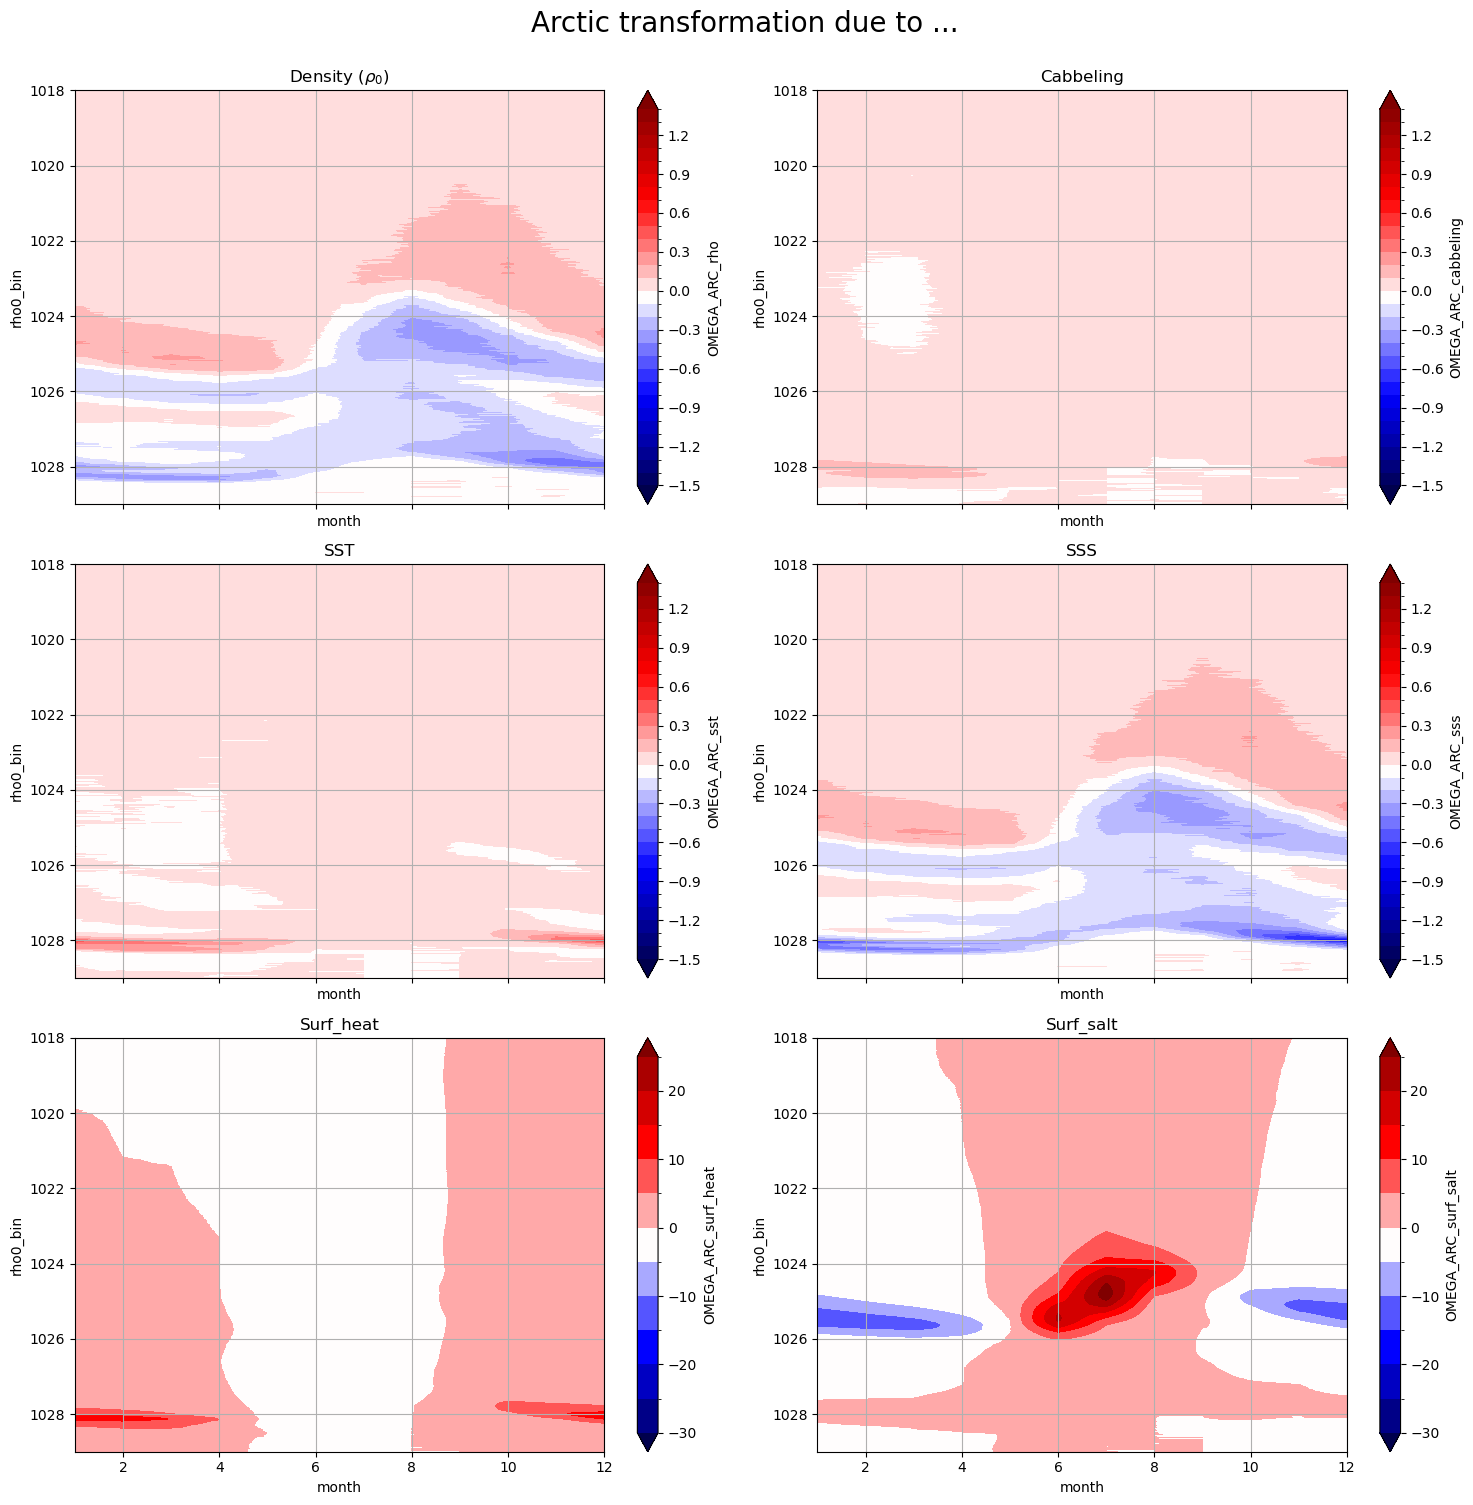

In [71]:
plotting(clim_arc, 'ARC_', 'Arctic')

## 3e) South monthly climatology

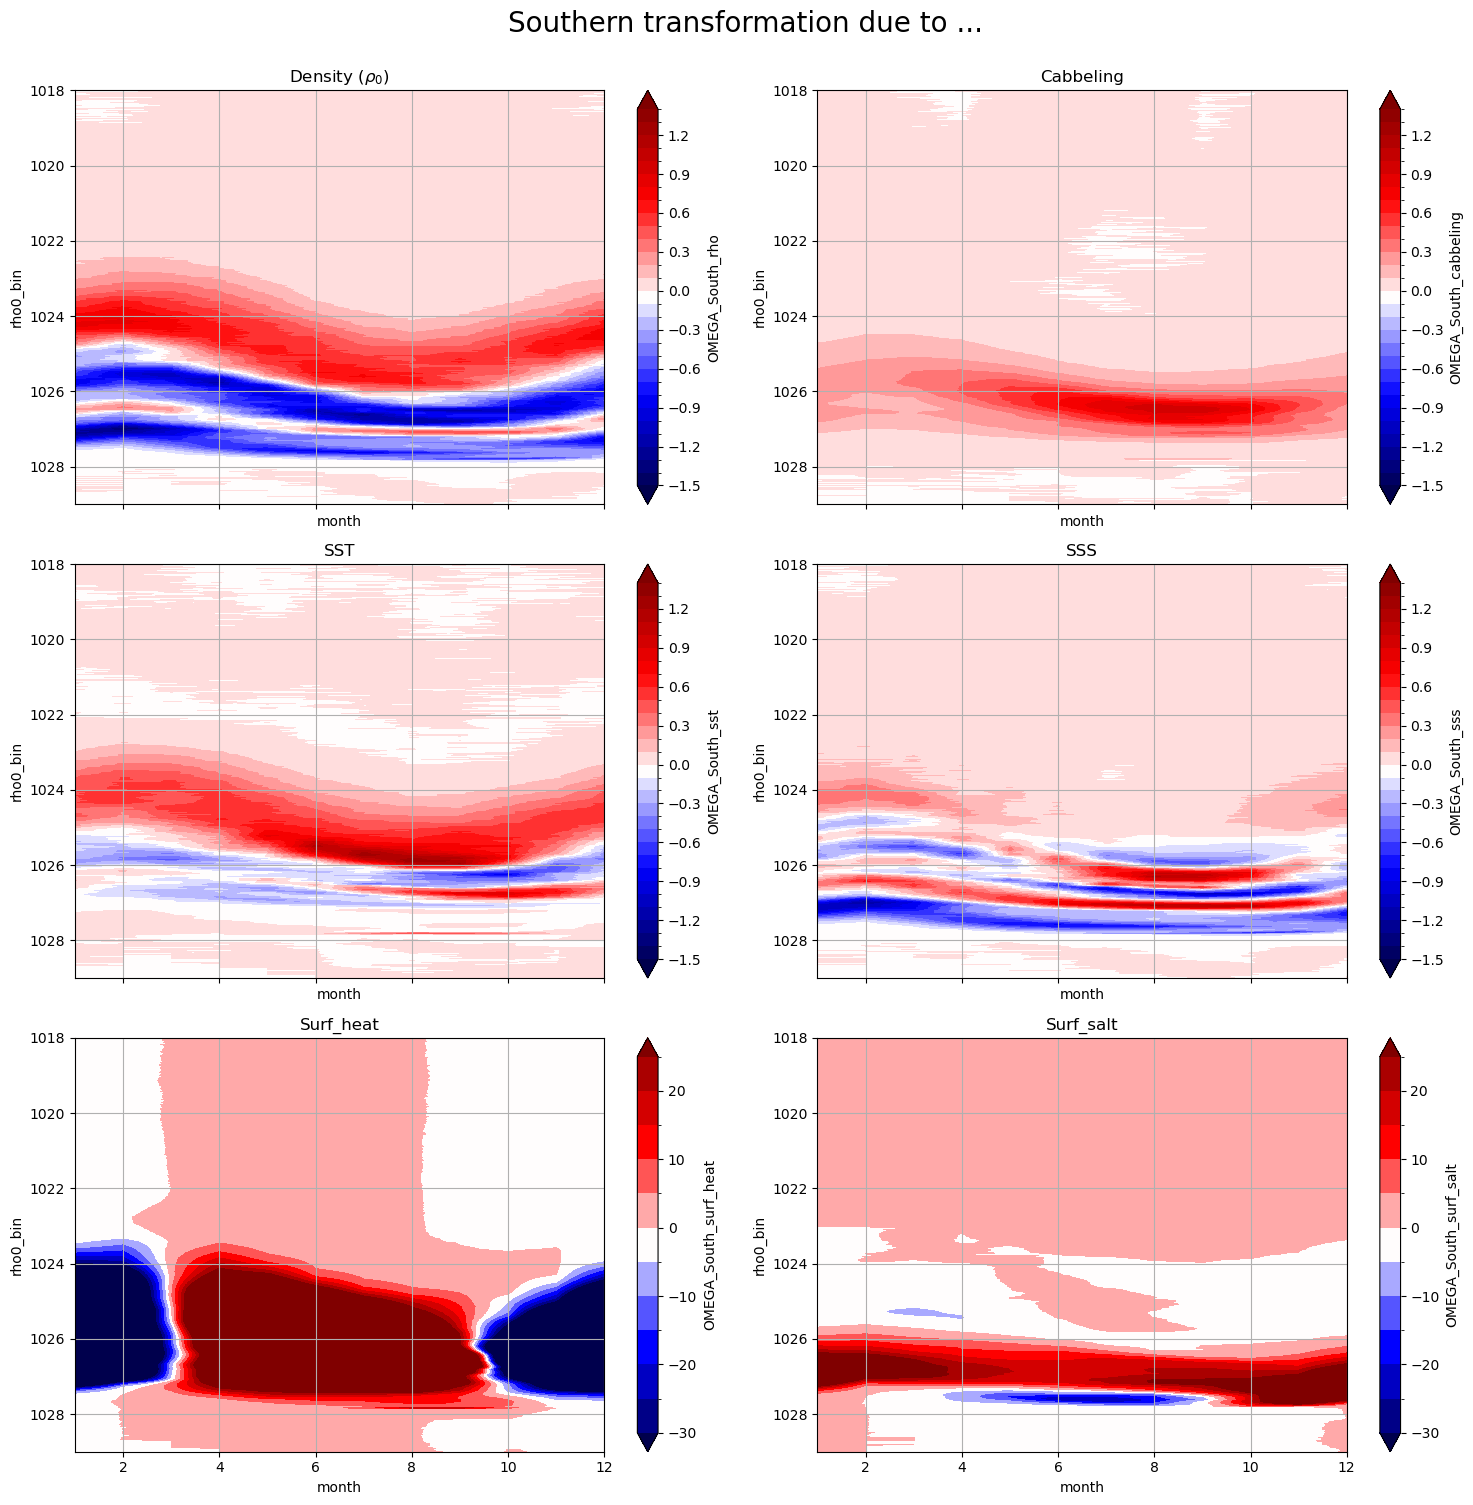

In [72]:
plotting(clim_south, 'South_', 'Southern')

In [73]:
cluster.close()
client.close()